[View in Colaboratory](https://colab.research.google.com/github/greenmoon1558/Basics/blob/master/%D1%81%D1%85%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D0%B8_%D0%B0%D0%BF%D0%BF%D1%80%D0%BE%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D1%86%D0%B8%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B9.ipynb)

# Задача 1: сравнение предложений
Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:
  *  кошки (животные)
  *  UNIX-утилита cat для вывода содержимого файлов
  *  версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.
sentences.txt
----------------------

### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n * d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание. Само предложение (In comparison to dogs, cats have not undergone... ) имеет индекс 0.
7. Запишите полученные числа в файл, разделив пробелом. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-1.txt).
8. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова. Позже мы будем подробно изучать анализ текстов, где выясним, как достичь высокого качества в задаче поиска похожих предложений.

In [0]:
import numpy as np
import re
from scipy.spatial import distance
with open("sentences.txt", mode="r", encoding="utf-8") as myFile:
    sentences = np.array(myFile.read().splitlines())
    split_sentences = np.array(list([s for s in re.split('[^a-z]', sentence.lower()) if s]  for sentence in sentences))
    world_dictionary = dict()
    worlds = np.unique([cell for cell in (cell for row in split_sentences for cell in row)])
    for world in worlds: 
        if not(world in world_dictionary) :
            world_dictionary[world] = len(world_dictionary)
    world_matrix = np.empty([len(split_sentences), len(world_dictionary)])
    for i, sentence in enumerate(split_sentences) :
        for world in world_dictionary:
            world_matrix[i][world_dictionary[world]] = sentence.count(world) 
    cosine_distance = np.empty((len(world_matrix[1:])))
    for i, sentence in enumerate(world_matrix[1:]):
        if i!=0:
            cosine_distance[i] = distance.cosine(world_matrix[0,:], sentence)
    with open("submission-1.txt", mode="w", encoding="utf-8") as myWriteFile:
        myWriteFile.write("{0} {1}".format(np.argmin(cosine_distance), np.argmin(np.delete(cosine_distance, np.argmin(cosine_distance)))))
    print(np.argmin(cosine_distance), np.argmin(np.delete(cosine_distance, np.argmin(cosine_distance))))

5 3


# Задача 2: аппроксимация функции
Рассмотрим сложную математическую функцию на отрезке [1, 15]:
$$f(x) = sin(\frac{x}{5}) \dot{} exp(x / 10) + 5 * exp(-x / 2)$$


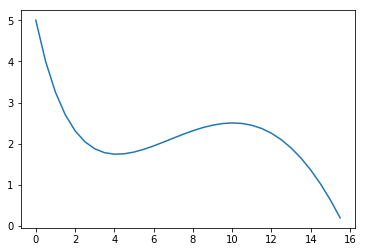

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 16, 0.5)
y = np.sin(x/5) * np.exp(x/10.0) + 5 * np.exp(-x / 2)
plt.plot(x, y)
plt.show()

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть w_0 + w_1 x + w_2 x^2 + ... + w_n x^n) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты w_0, ... w_n можно определить из следующей системы линейных уравнений:

где через $$x_1, ..., x_n, x_{n+1}$$ обозначены точки, через которые проходит многочлен, а через $$f(x_1), ..., f(x_n), f(x_{n+1})$$ — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию? Коэффициенты данного многочлена (четыре числа в следующем порядке: w_0, w_1, w_2, w_3) являются ответом на задачу. Округлять коэффициенты не обязательно, но при желании можете произвести округление до второго знака (т.е. до числа вида 0.42)
4. Запишите полученные числа в файл, разделив пробелами. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-2.txt).


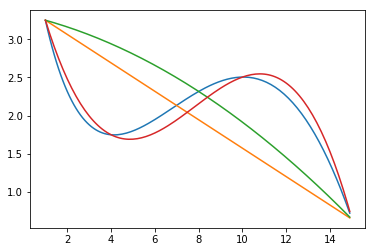

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve

def f(x):
    return np.sin(x/5)*np.exp(x/10)+5*np.exp(-x/2)

x = np.arange(1, 15, 0.1)
y = f(x)

x_1 = np.array([1, 15])
line_1 = np.polyfit(x_1, f(x_1), 1)
w_1 = np.poly1d(line_1)
y_1 = w_1(x)

x_2 = np.array([1, 8, 15])
line_2 = np.polyfit(x_2, f(x_2), 2)
w_2 = np.poly1d(line_2)
y_2 = w_2(x)

x_3 = np.array([1, 4, 10, 15])
line_3 = np.polyfit(x_3, f(x_3), 3)
w_3 = np.poly1d(line_3)
y_3 = w_3(x)

plt.plot(x, y,'-',
         x, y_1, '-',
         x, y_2, '-',
         x, y_3, '-')
plt.show()
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
with open("submission-2.txt", mode="w", encoding="utf-8") as myWriteFile:
        myWriteFile.write("{0} {1} {2} {3}".format(float_formatter(line_3[0]), float_formatter(line_3[1]), float_formatter(line_3[2]), float_formatter(line_3[3])))
